# DAX Index: Time Series

## 274403

In [109]:
import pandas as pd 
import polars as pl 
import numpy as np
import matplotlib.pyplot as plt
import time 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima

from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from IPython.core.debugger import set_trace



In [55]:
df = pd.read_csv('DAX Historical Results Price Data.csv') 
df 

,Date,Price,Open,High,Low,Vol.,Change %
0,13/03/2025,"22,570.48","22,565.00","22,758.46","22,417.83",40.64M,-0.47%
1,12/03/2025,"22,676.41","22,525.74","22,813.84","22,461.77",80.93M,1.56%
2,11/03/2025,"22,328.77","22,680.39","22,835.10","22,258.30",97.37M,-1.29%
3,10/03/2025,"22,620.95","23,163.78","23,164.24","22,519.21",108.71M,-1.69%
4,07/03/2025,"23,008.94","23,195.22","23,234.28","22,860.08",106.64M,-1.75%
...,...,...,...,...,...,...,...
2584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2587,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df = df[['Date','Price']].rename(columns={'Price': 'close', 'Date': 'date'})
df 

,date,close
0,13/03/2025,"22,570.48"
1,12/03/2025,"22,676.41"
2,11/03/2025,"22,328.77"
3,10/03/2025,"22,620.95"
4,07/03/2025,"23,008.94"
...,...,...
2584,NaN,NaN
2585,NaN,NaN
2586,NaN,NaN
2587,NaN,NaN


In [57]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.set_index('date', inplace=True)
df

,close
date,
2025-03-13,"22,570.48"
2025-03-12,"22,676.41"
2025-03-11,"22,328.77"
2025-03-10,"22,620.95"
2025-03-07,"23,008.94"
...,...
NaT,NaN
NaT,NaN
NaT,NaN


In [58]:
df = df.sort_index(ascending=True)  # If the index is a datetime

In [59]:
df

,close
date,
2015-03-13,"11,901.61"
2015-03-16,"12,167.72"
2015-03-17,"11,980.85"
2015-03-18,"11,922.77"
2015-03-19,"11,899.40"
...,...
NaT,NaN
NaT,NaN
NaT,NaN


In [60]:
df.describe()

,close
count,2539
unique,2537
top,"11,815.01"
freq,2


# Stationarity

## ADF Test

Null hypothesis of ADF Test is the time-series is not stationary.


So if p-value < 0.05 significance level, reject Ho and infer time-series is indeed stationary. 

If p-value > 0.05, need to find order of differencing.

In [61]:
# df = df.dropna(subset=['close'])
# df.shape

In [62]:
# Sum the rows that contain null values
null_sum = df[df.isnull().any(axis=1)].sum()
print(null_sum)

close    0
dtype: object


In [63]:
# Remove commas and convert to numeric
df['close'] = df['close'].str.replace(',', '').astype(float)

# Forward fill missing values to handle any gaps in the data
df = df.fillna(method='ffill')

# Perform Augmented Dickey-Fuller (ADF) test to check for stationarity
result = adfuller(df['close'])

# Print the ADF Statistic
print('ADF Statistic: %f' % result[0])

# Print the p-value to determine the significance
print('p-value: %f' % result[1])

# Print the critical values at different confidence levels to compare with the ADF Statistic
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Interpretation



ADF Statistic: 0.331935
p-value: 0.978763
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


/var/folders/pl/vldk2f117ps7jbp86h049rxc0000gn/T/ipykernel_51587/587420137.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [64]:
# The Augmented Dickey-Fuller (ADF) test is used to check for stationarity in a time series. Here is the interpretation of the results:

# ADF Statistic: 0.331935: This is the test statistic calculated by the ADF test.
# p-value: 0.978763: This is the probability of observing the test statistic under the null hypothesis. A high p-value (typically > 0.05) indicates that we fail to reject the null hypothesis.
# Critical Values: These are the threshold values at different confidence levels (1%, 5%, and 10%). If the ADF statistic is less than the critical value, we reject the null hypothesis.
# In this case:

# The ADF Statistic (0.331935) is greater than all the critical values (-3.433, -2.863, -2.567).
# The p-value (0.978763) is much higher than 0.05.
# Conclusion: We fail to reject the null hypothesis, which means the time series is non-stationary. This suggests that the time series has a unit root and does not have a constant mean and variance over time.

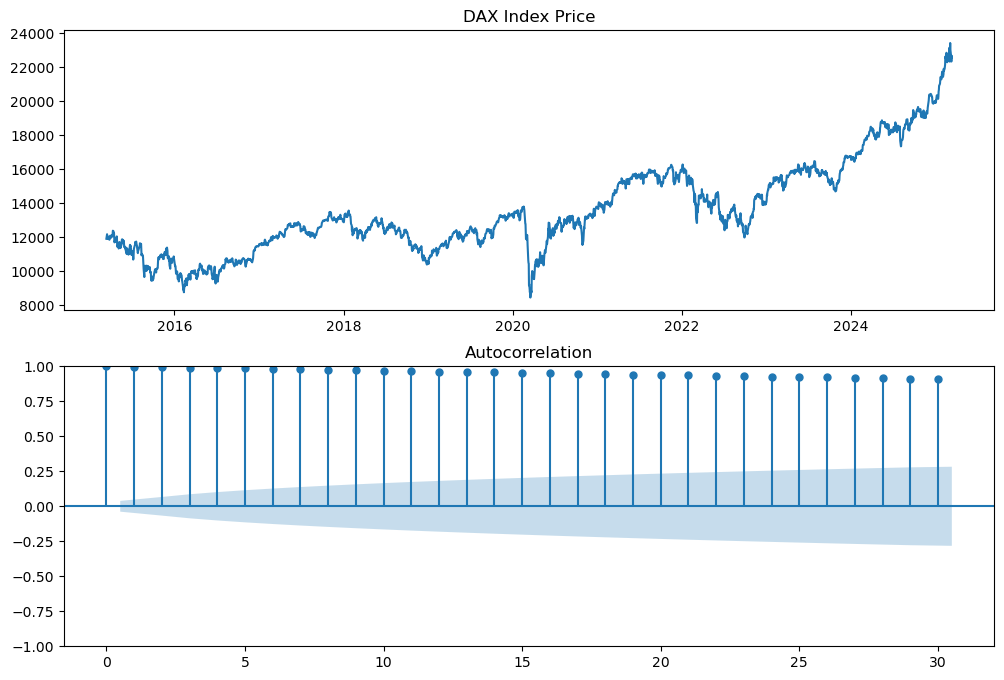

In [65]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(df['close'])
ax1.set_title('DAX Index Price')
plot_acf(df['close'], ax=ax2, lags=30);

## Differencing (d=1)

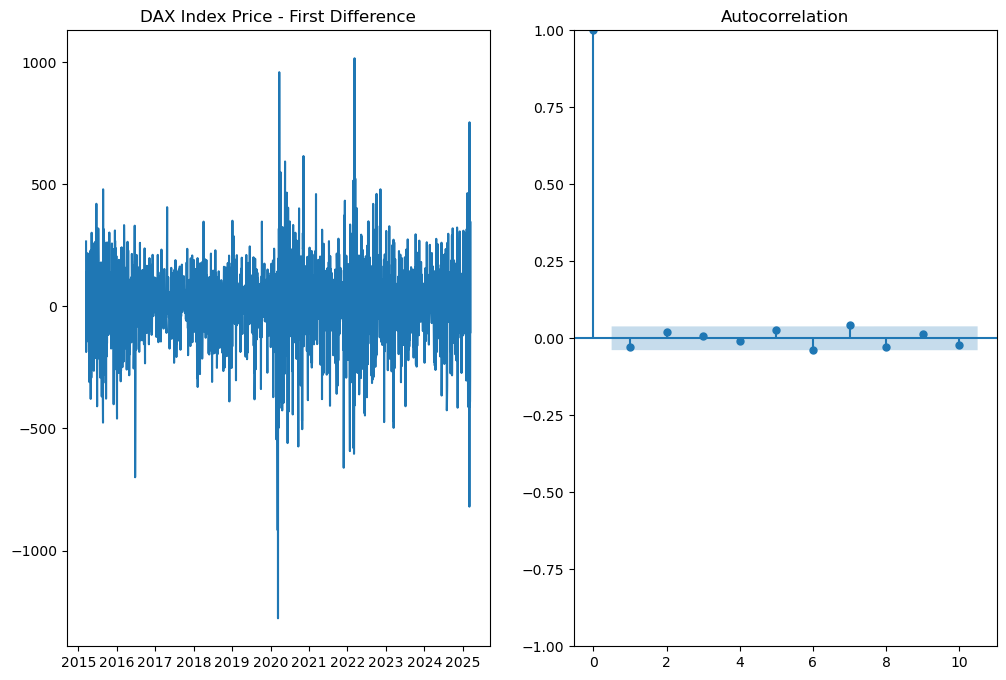

In [66]:
diff = df['close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(diff)
ax1.set_title('DAX Index Price - First Difference')
plot_acf(diff, ax=ax2, lags=10);

In [67]:
# based on chart, d=1

# and to further confirm:
ndiffs(df['close'], test='adf')

1

## d = 1

## Autoregressive Term (p) - using partial autocorrelation PACF plot

represents correl between the series and its lags

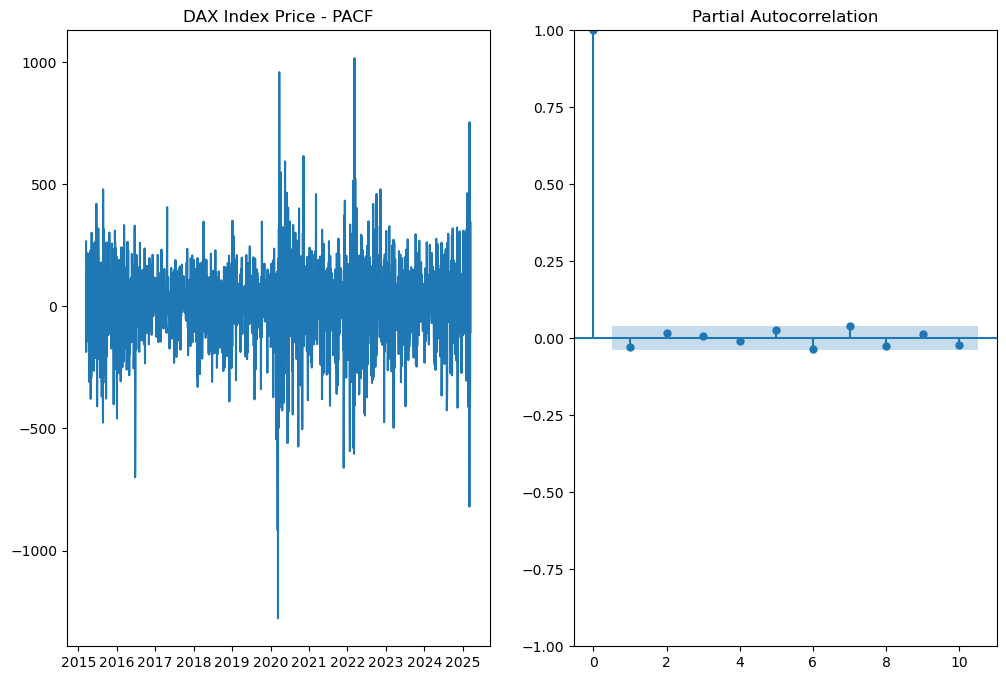

In [68]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(diff)
ax1.set_title('DAX Index Price - PACF')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2, lags=10);

## p = 2

## Moving Average Term (q) 

Refers to the number of lagged forecast errors that should go into the ARIMA model

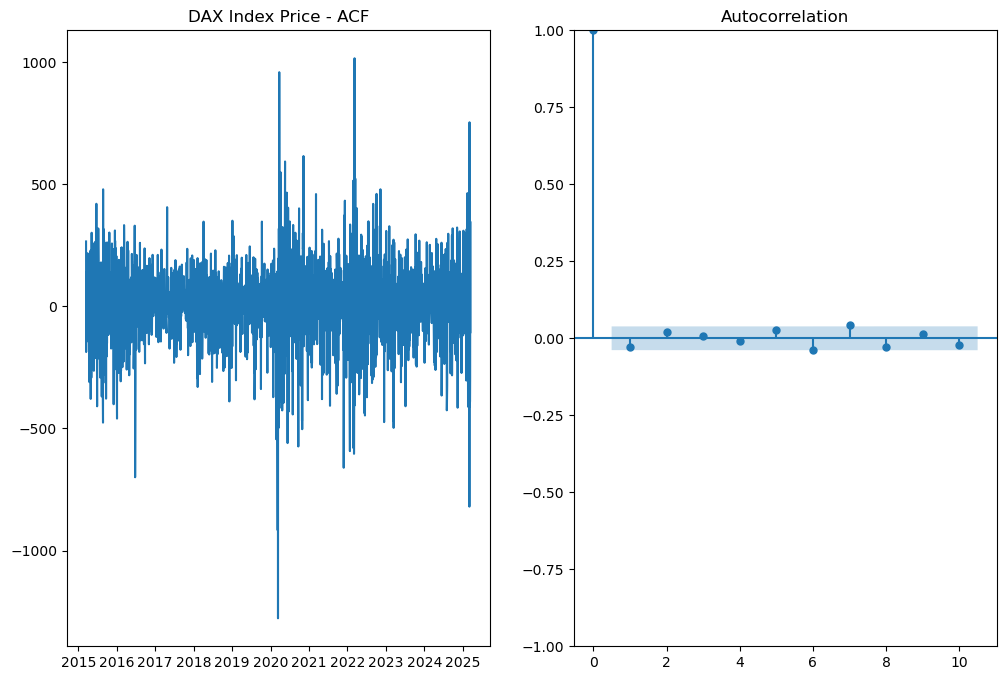

In [69]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(diff)
ax1.set_title('DAX Index Price - ACF')
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2, lags=10);

## q = 0

## Fitting ARIMA Model

In [70]:
# model = ARIMA(df['close'], order=(0, 1, 0)) # p=0, d=1, q=0
# result = model.fit()

In [71]:
# print(result.summary())


In [72]:
# if any of the coef are close to zero you can remove that term


In [73]:
stepwise_fit = auto_arima(df['close'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33343.103, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33337.854, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33337.879, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33337.948, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33337.768, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33339.557, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.820 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2589
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -16667.884
Date:                Wed, 26 Mar 2025   AIC                          33337.768
Time:                        17:34:29   BIC                          33343.627
Sample:                             0   HQIC                         33339.891
                               - 2589                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.299e+04    328.452     69.982      0.000    2.23e+04    2.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.15   Jarque-Bera (JB):              3475.97
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
# The results provided are from fitting various ARIMA models to the time series data and selecting the best model based on the Akaike Information Criterion (AIC). Here is the interpretation:

# Stepwise Search Results:
# ARIMA(2,1,2)(0,0,0)[0] intercept: AIC=33343.103
# ARIMA(0,1,0)(0,0,0)[0] intercept: AIC=33337.854
# ARIMA(1,1,0)(0,0,0)[0] intercept: AIC=33337.879
# ARIMA(0,1,1)(0,0,0)[0] intercept: AIC=33337.948
# ARIMA(0,1,0)(0,0,0)[0]: AIC=33337.768 (Best model)
# ARIMA(1,1,1)(0,0,0)[0] intercept: AIC=33339.557
# The best model selected is ARIMA(0,1,0)(0,0,0)[0] with the lowest AIC of 33337.768.

# SARIMAX Results:
# Dependent Variable: y
# Number of Observations: 2589
# Model: SARIMAX(0, 1, 0)
# Log Likelihood: -16667.884
# AIC: 33337.768
# BIC: 33343.627
# HQIC: 33339.891
# Covariance Type: opg
# Coefficients:
# sigma2: 2.299e+04 (Standard Error: 328.452, z: 69.982, P>|z|: 0.000, 95% CI: [2.23e+04, 2.36e+04])
# Diagnostic Tests:
# Ljung-Box (L1) (Q): 2.15 (Prob(Q): 0.14) - This test checks for autocorrelation in the residuals. A high p-value (> 0.05) indicates no significant autocorrelation.
# Jarque-Bera (JB): 3475.97 (Prob(JB): 0.00) - This test checks for normality of the residuals. A low p-value (< 0.05) indicates non-normality.
# Heteroskedasticity (H): 1.66 (Prob(H) (two-sided): 0.00) - This test checks for constant variance in the residuals. A low p-value (< 0.05) indicates heteroskedasticity.
# Skew: -0.41 - Indicates the asymmetry of the residuals.
# Kurtosis: 8.62 - Indicates the peakedness of the residuals.
# Conclusion:
# The best model selected is ARIMA(0,1,0), which is a simple random walk model. The diagnostic tests indicate that there might be some issues with the residuals, such as non-normality and heteroskedasticity. This suggests that while the model fits the data, there may be room for improvement or further investigation into the residuals.

## Plot Residual Errors

In [75]:
# residuals = pd.DataFrame(result.resid)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# ax1.plot(residuals)
# ax1.set_title('Residuals')
# ax2.hist(residuals, density=True)
# ax2.set_title('Residuals Histogram');

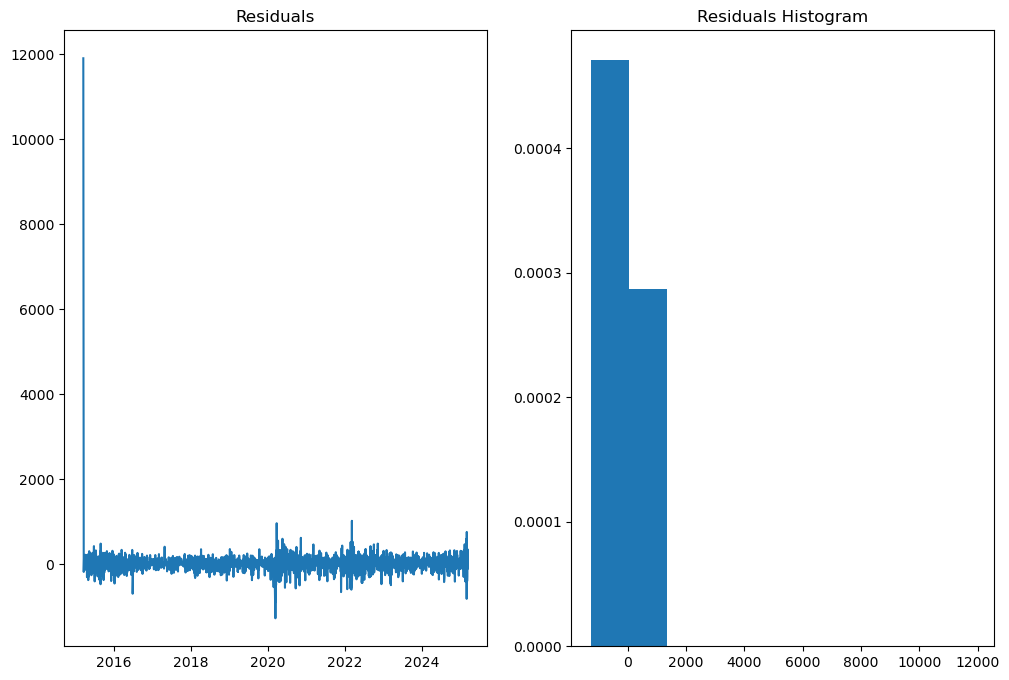

In [76]:
residuals = pd.DataFrame(stepwise_fit.resid())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(residuals)
ax1.set_title('Residuals')
ax2.hist(residuals, density=True)
ax2.set_title('Residuals Histogram');

# #NOTE do Whitenoise test after residuals

     lb_stat  lb_pvalue
10  3.778801   0.956774


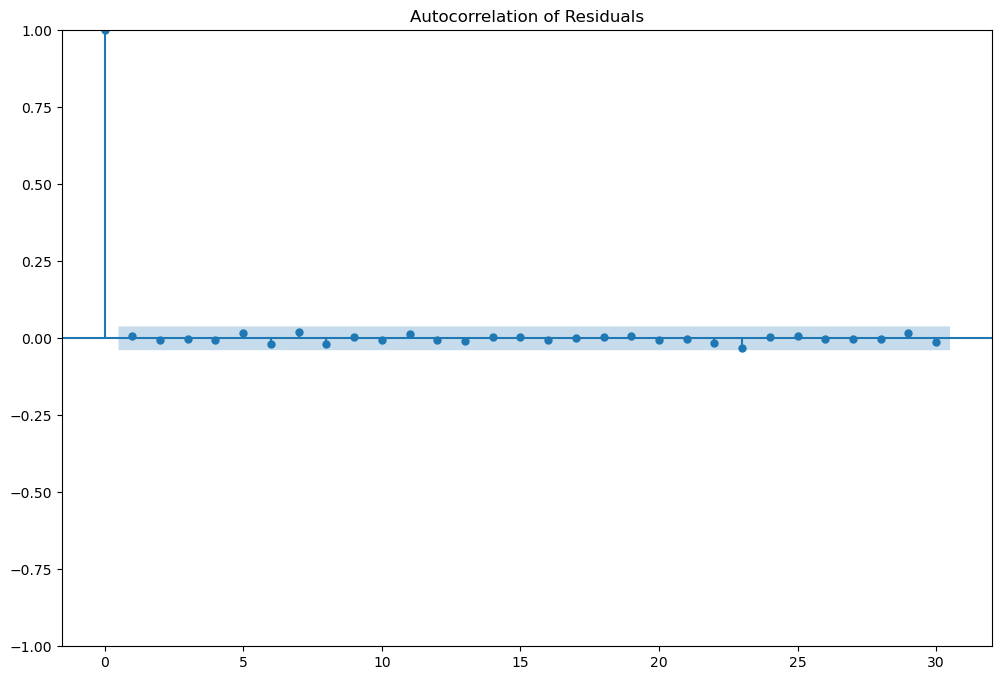

In [77]:


# Perform the Ljung-Box test for white noise
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)

# Plot the autocorrelation of the residuals
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(residuals, ax=ax, lags=30)
ax.set_title('Autocorrelation of Residuals')
plt.show()

In [78]:
# The results of your Ljung-Box test and the autocorrelation function (ACF) plot indicate the following:

# Ljung-Box Test Interpretation:

# Null Hypothesis (H₀): The residuals are independently distributed (no autocorrelation).
# Alternative Hypothesis (H₁): The residuals are not independently distributed (significant autocorrelation).
# Key Results:

# Test Statistic (lb_stat): 3.778
# p-value: 0.957

# Conclusion:

# The p-value (0.957) is much larger than common significance levels (e.g., 0.05 or 0.01). This means there is no strong evidence to reject the null hypothesis.
# Interpretation: The residuals exhibit no significant autocorrelation up to lag 10. This suggests your model has adequately captured the underlying patterns in the data, leaving residuals that resemble white noise.
# ACF Plot Context:

# The ACF plot of residuals (up to lag 30) likely shows:

# Most autocorrelation values (vertical lines) within the blue confidence band (typically 95% confidence interval).
# This visually reinforces the Ljung-Box result: no significant autocorrelation at any lag.

# Practical Implications:

# Model Validation: Your model passes a critical diagnostic check for autocorrelation in residuals.
# Next Steps: If your goal was to ensure residuals are white noise (e.g., in ARIMA modeling), this result is favorable. However, always check other diagnostics (e.g., residual distribution, heteroscedasticity).
# Caveats:

# The test only checks autocorrelation up to lag 10 (as specified by lags=[10]). If you suspect seasonality or longer-term dependencies, consider testing higher lags.
# Always combine statistical tests with visual inspection (e.g., the ACF plot) for a comprehensive analysis.

In [79]:
df.shape

(2589, 1)

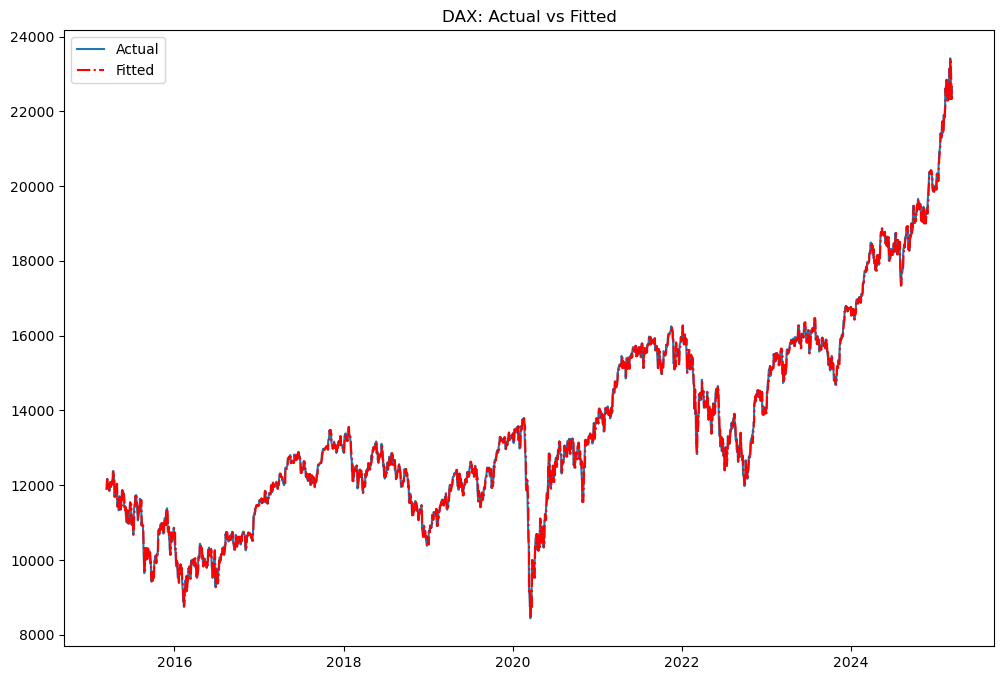

In [80]:
# Actual vs Fitted
predictions = stepwise_fit.predict_in_sample(start=1, end=2588)
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['close'], label='Actual')
plt.plot(df.index[1:2589], predictions, label='Fitted', color='red', linestyle='-.')
plt.legend()
plt.title('DAX: Actual vs Fitted')
plt.show()

## Note: ARIMA is not good for trading. You cannot simply use close prices to predict future prices.

In [81]:
# # Ensure the index is a valid datetime
# df.index = pd.to_datetime(df.index)

# # Drop any NaT values from the index (if necessary)
# df = df[df.index.notna()]

# # Define the number of steps to predict into the future
# steps = 6

# # Make predictions
# future_predictions = stepwise_fit.predict(n_periods=steps)

# # Create a date range for the future predictions
# last_date = df.index[-1]
# future_dates = pd.date_range(start=last_date, periods=steps + 1, freq='B')[1:]

# # Create a DataFrame to hold the future predictions
# future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted_Close'])

# # Plot the actual data and future predictions
# plt.figure(figsize=(12, 8))
# plt.plot(df.index, df['close'], label='Actual')
# plt.plot(future_df.index, future_df['Predicted_Close'], label='Future Predictions', color='red')
# plt.legend()
# plt.title('DAX: Actual vs Future Predictions')
# plt.show()

In [82]:


# 1) Ensure the df index is datetime
df.index = pd.to_datetime(df.index)
df = df[df.index.notna()]  # drop rows with invalid dates

# 2) Train a more flexible ARIMA
stepwise_fit = auto_arima(
    df['close'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None, 
    seasonal=False,  # Turn off seasonal if your data isn't periodic
    trend='t',       # Allow a linear trend (drift)
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print(stepwise_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2539
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -16367.541
Date:                Wed, 26 Mar 2025   AIC                          32741.082
Time:                        17:34:31   BIC                          32758.600
Sample:                             0   HQIC                         32747.437
                               - 2539                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0043      0.002      2.199      0.028       0.000       0.008
ar.L1         -0.0285      0.014     -1.994      0.046      -0.057      -0.000
sigma2      2.337e+04    342.386     68.258      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


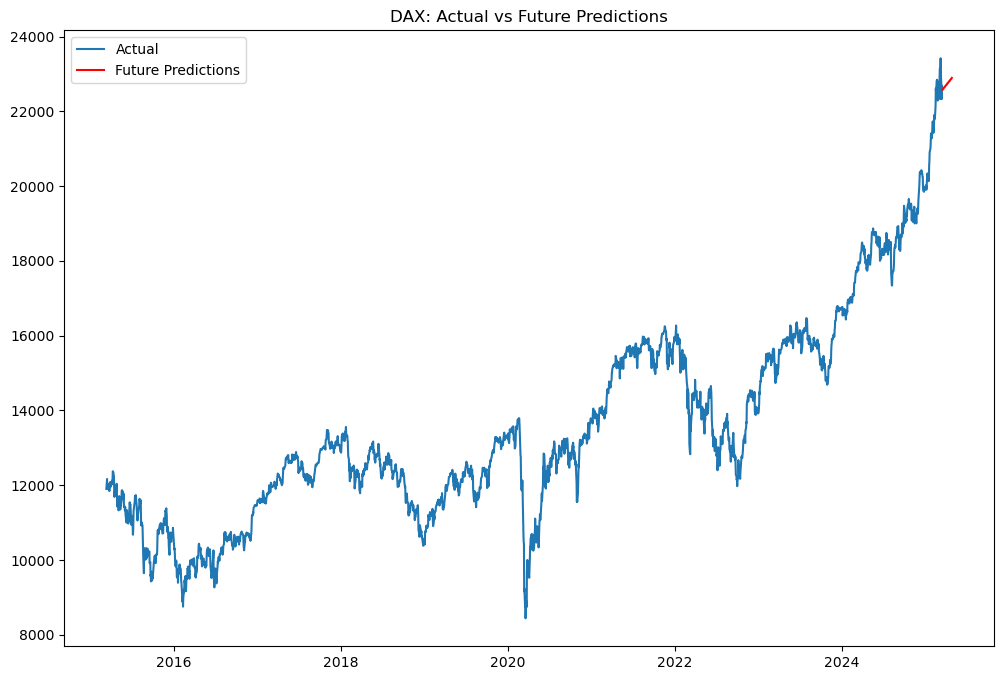

In [83]:

# 3) Predict future
steps = 30
future_predictions = stepwise_fit.predict(n_periods=steps)

# 4) Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=steps+1, freq='B')[1:]

# 5) Align the predictions with the new dates
future_df = pd.DataFrame(
    future_predictions.values,  
    index=future_dates, 
    columns=['Predicted_Close']
)

# 6) Plot
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['close'], label='Actual')
plt.plot(future_df.index, future_df['Predicted_Close'], label='Future Predictions', color='red')
plt.title('DAX: Actual vs Future Predictions')
plt.legend()
plt.show()


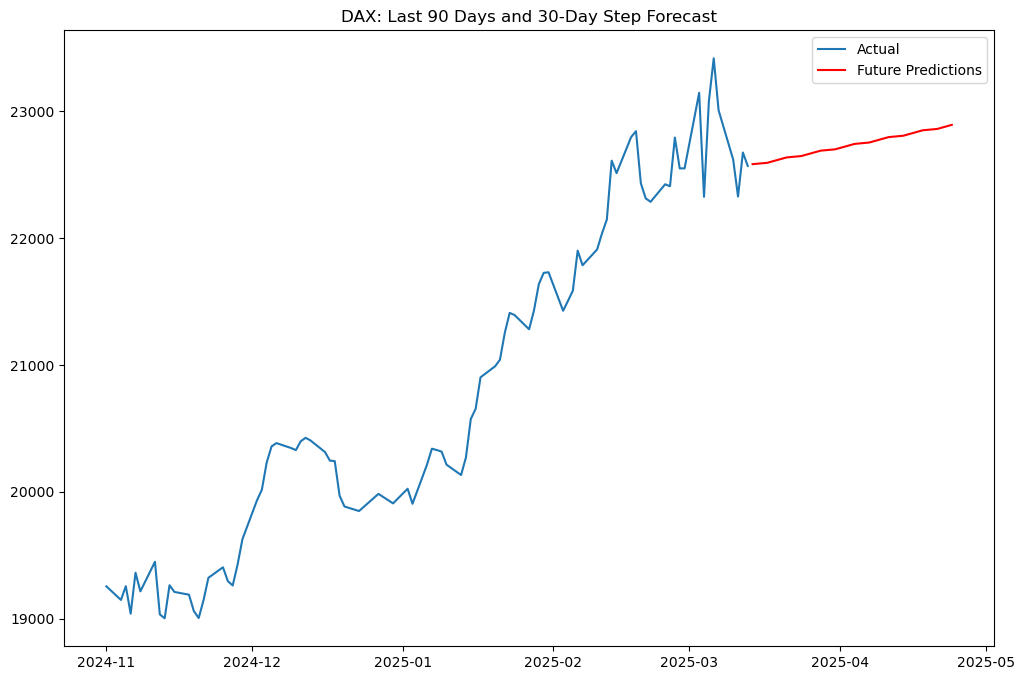

In [84]:
# Define the number of days to plot
days_to_plot = 90

# Get the last 90 days of actual data
last_90_days = df['close'].iloc[-days_to_plot:]

# Plot the last 90 days and the 30-day step forecast
plt.figure(figsize=(12, 8))
plt.plot(last_90_days.index, last_90_days, label='Actual')
plt.plot(future_df.index, future_df['Predicted_Close'], label='Future Predictions', color='red')
plt.title('DAX: Last 90 Days and 30-Day Step Forecast')
plt.legend()
plt.show()

In [85]:
future_df

,Predicted_Close
2025-03-14,22584.437133
2025-03-17,22594.978949
2025-03-18,22605.622488
2025-03-19,22616.267434
2025-03-20,22626.916646
2025-03-21,22637.570044
2025-03-24,22648.227629
2025-03-25,22658.889402
2025-03-26,22669.555363
2025-03-27,22680.225511


In [86]:
future_predictions

2539    22584.437133
2540    22594.978949
2541    22605.622488
2542    22616.267434
2543    22626.916646
2544    22637.570044
2545    22648.227629
2546    22658.889402
2547    22669.555363
2548    22680.225511
2549    22690.899847
2550    22701.578370
2551    22712.261081
2552    22722.947980
2553    22733.639066
2554    22744.334340
2555    22755.033802
2556    22765.737451
2557    22776.445288
2558    22787.157312
2559    22797.873524
2560    22808.593923
2561    22819.318510
2562    22830.047285
2563    22840.780248
2564    22851.517398
2565    22862.258735
2566    22873.004260
2567    22883.753973
2568    22894.507874
dtype: float64

In [87]:
# # Calculate the returns
# returns = df['close'].pct_change().dropna()

# # Plot the 'close' prices and the returns
# fig, ax1 = plt.subplots(figsize=(12, 8))

# # Plot the 'close' prices on the primary y-axis
# ax1.plot(df.index, df['close'], label='Close Price', color='blue')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Close Price', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# # Create a secondary y-axis to plot the returns
# ax2 = ax1.twinx()
# ax2.plot(returns.index, returns, label='Returns', color='green')
# ax2.set_ylabel('Returns', color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# # Add a title and legend
# fig.suptitle('DAX: Close Price and Returns')
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.show()

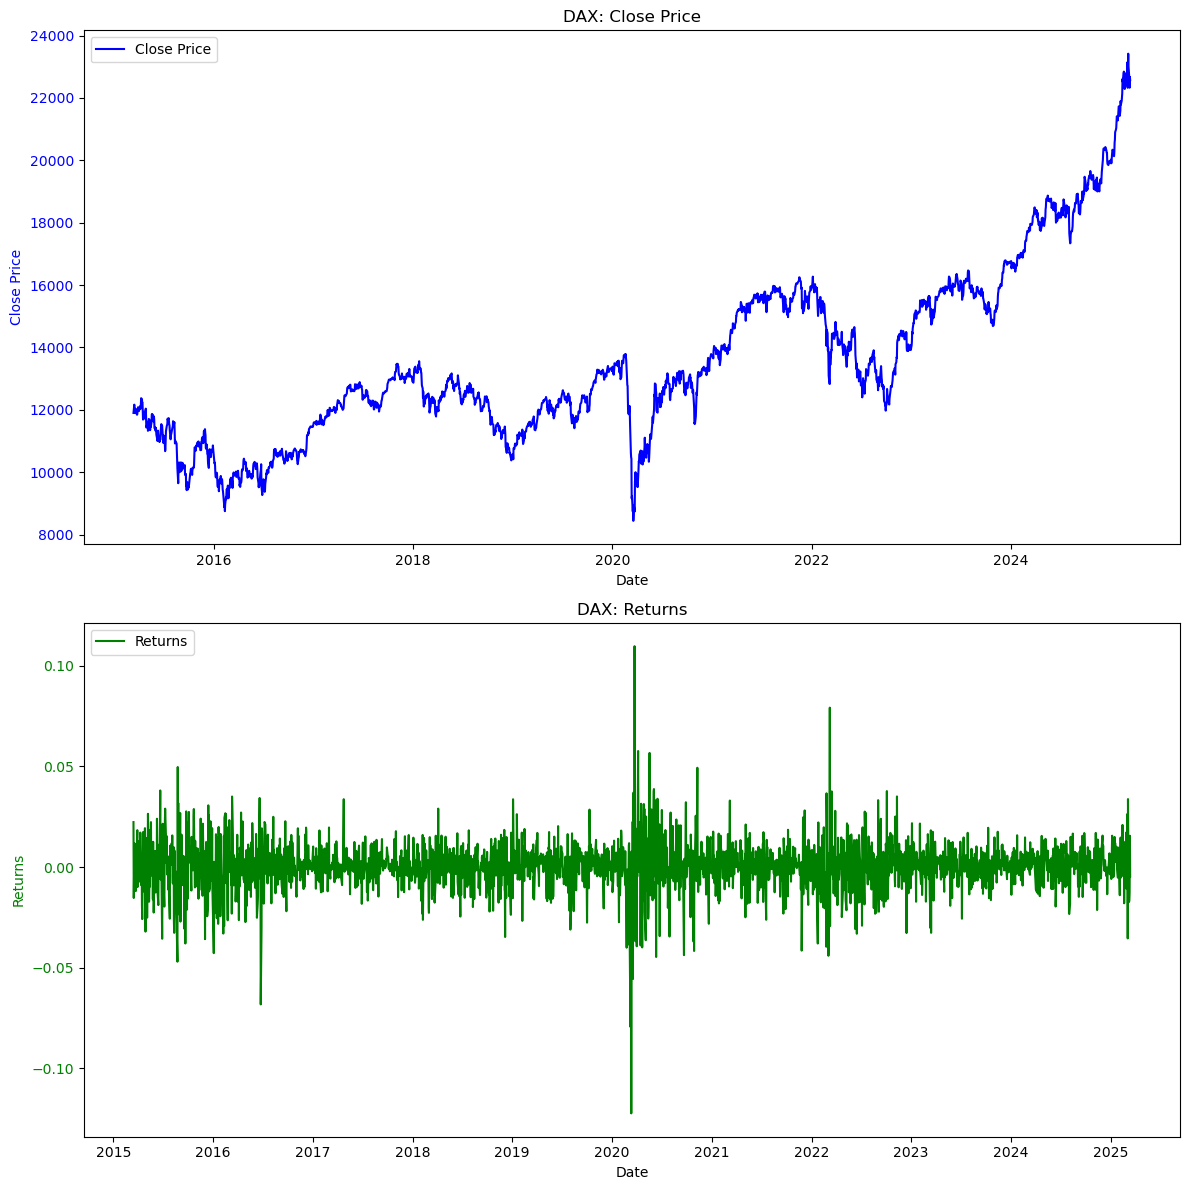

In [88]:
# # Calculate the returns
returns = df['close'].pct_change().dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the 'close' prices on the first subplot
ax1.plot(df.index, df['close'], label='Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('DAX: Close Price')

# Plot the returns on the second subplot
ax2.plot(returns.index, returns, label='Returns', color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title('DAX: Returns')

# Add a legend to each subplot
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [89]:
# First do ARCH.
# If significant (prob or p-value < 0.05), then do GARCH.
# after 

In [90]:


# Fit an ARCH(1) model to the data
arch_model_instance = arch_model(df['close'], vol='ARCH', p=1)
arch_fit = arch_model_instance.fit(disp='off')

# Print the summary of the fitted model
print(arch_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -22296.2
Distribution:                  Normal   AIC:                           44598.5
Method:            Maximum Likelihood   BIC:                           44616.0
                                        No. Observations:                 2539
Date:                Wed, Mar 26 2025   Df Residuals:                     2538
Time:                        17:34:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2587e+04     39.434    319.204      0.000 [1.

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.305e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [91]:
# p>|t| < 0.05, therefore do GARCH

In [92]:


# Fit a GARCH(1,1) model to the 'close' data
garch_model = arch_model(df['close'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Print the summary of the fitted model
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -21936.1
Distribution:                  Normal   AIC:                           43880.2
Method:            Maximum Likelihood   BIC:                           43903.5
                                        No. Observations:                 2539
Date:                Wed, Mar 26 2025   Df Residuals:                     2538
Time:                        17:34:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2528e+04     49.716    251.993      0.000 [1.

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.305e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


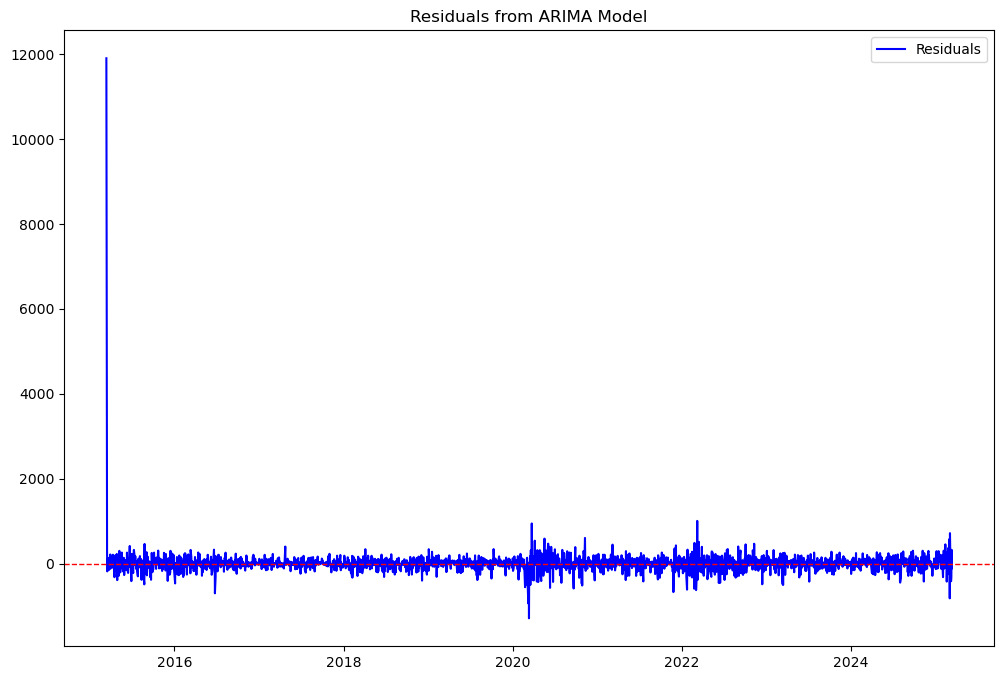

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.916e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.916e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -16358.9
Distribution:                  Normal   AIC:                           32723.7
Method:            Maximum Likelihood   BIC:                           32741.2
                                        No. Observations:                 2539
Date:                Wed, Mar 26 2025   Df Residuals:                     2538
Time:                        17:34:32   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3.2497      3.071      1.058      0.290 [ -2.769,  9.26

In [93]:
# Calculate residuals from the ARIMA model
residuals = stepwise_fit.resid()

# Plot residuals
plt.figure(figsize=(12, 8))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals from ARIMA Model')
plt.legend()
plt.show()

# Fit an ARCH(1) model to the residuals
arch_model_instance = arch_model(residuals, vol='ARCH', p=1)
arch_fit = arch_model_instance.fit(disp='off')
print(arch_fit.summary())

# Fit a GARCH(1,1) model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

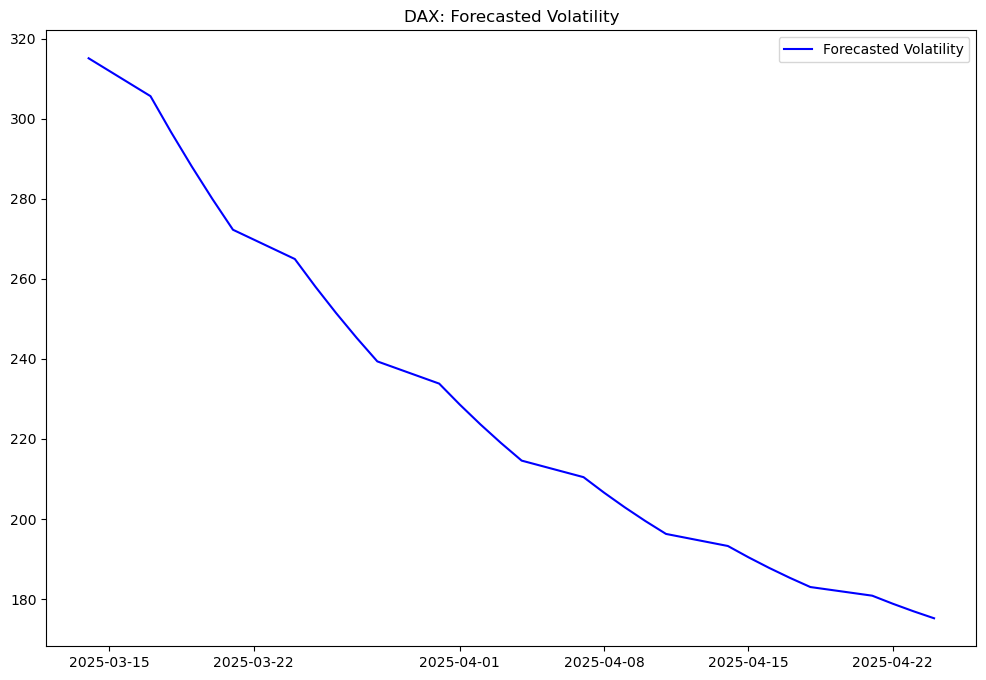

In [94]:
# Forecast future volatility
steps = 30
garch_forecast = garch_fit.forecast(horizon=steps)

# Extract the forecasted volatility
forecasted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# Create future dates for the forecasted volatility
future_vol_dates = pd.date_range(start=last_date, periods=steps + 1, freq='B')[1:]

# Plot the forecasted volatility
plt.figure(figsize=(12, 8))
plt.plot(future_vol_dates, forecasted_volatility, label='Forecasted Volatility', color='blue')
plt.title('DAX: Forecasted Volatility')
plt.legend()
plt.show()

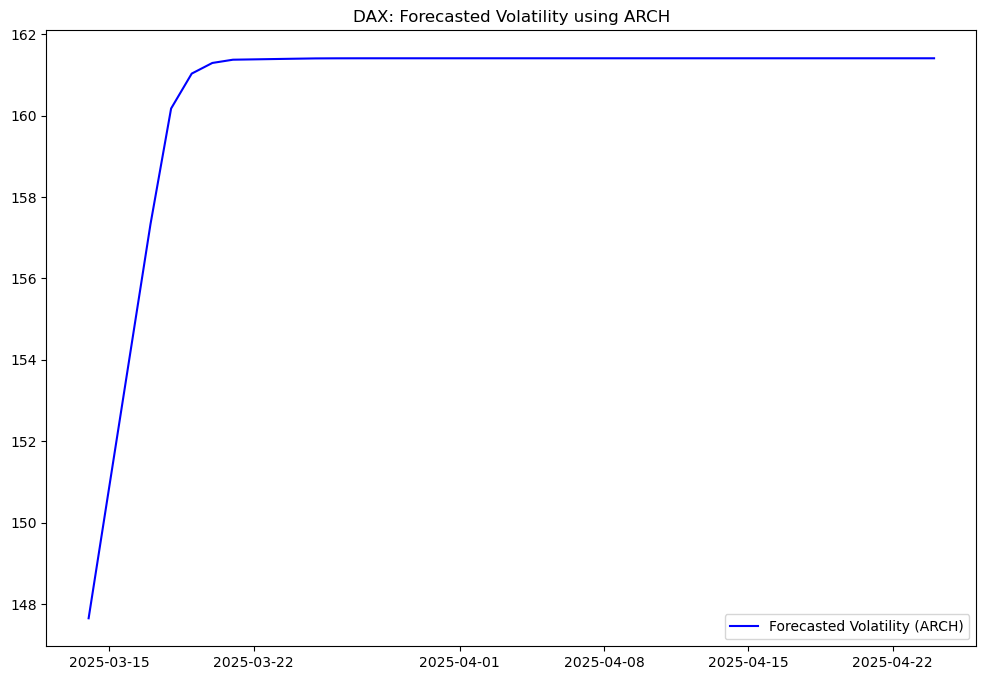

In [95]:
# Forecast future volatility using the ARCH model
arch_forecast = arch_fit.forecast(horizon=steps)

# Extract the forecasted volatility
arch_forecasted_volatility = np.sqrt(arch_forecast.variance.values[-1, :])

# Create future dates for the forecasted volatility
arch_future_vol_dates = pd.date_range(start=last_date, periods=steps + 1, freq='B')[1:]

# Plot the forecasted volatility
plt.figure(figsize=(12, 8))
plt.plot(arch_future_vol_dates, arch_forecasted_volatility, label='Forecasted Volatility (ARCH)', color='blue')
plt.title('DAX: Forecasted Volatility using ARCH')
plt.legend()
plt.show()

In [96]:
# Display the forecasted volatility values from the ARCH forecast
print("Forecasted Volatility (ARCH):")
print(arch_forecasted_volatility)

Forecasted Volatility (ARCH):
[147.65395014 157.33107886 160.17149619 161.0294363  161.29068295
 161.37042656 161.3947856  161.40222815 161.40450226 161.40519715
 161.40540948 161.40547436 161.40549419 161.40550025 161.4055021
 161.40550266 161.40550284 161.40550289 161.40550291 161.40550291
 161.40550291 161.40550291 161.40550291 161.40550291 161.40550291
 161.40550291 161.40550291 161.40550291 161.40550291 161.40550291]


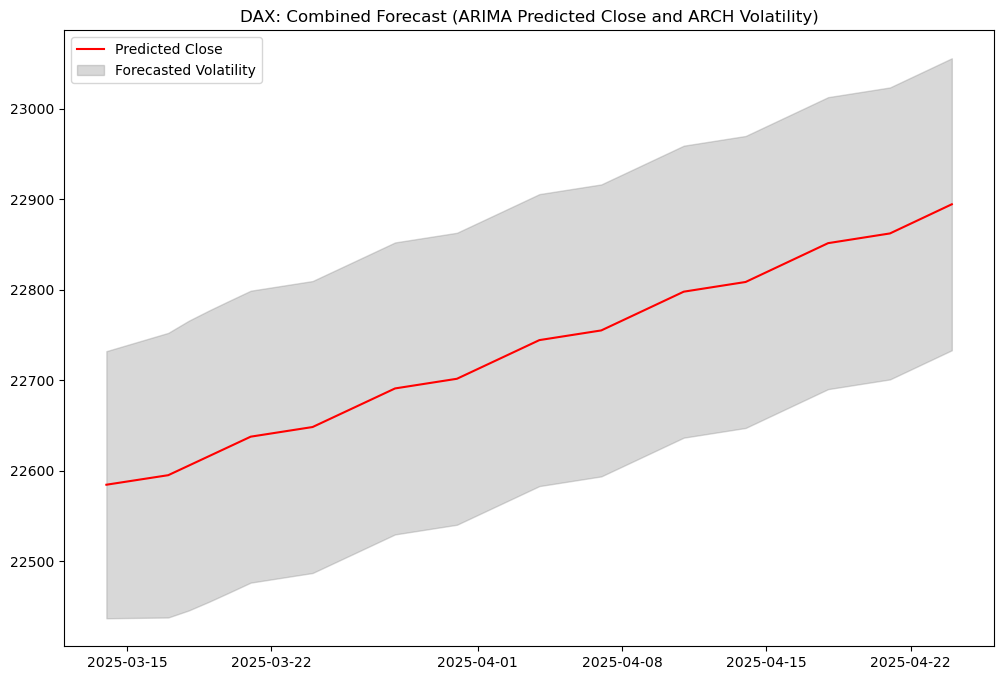

In [97]:
# Combine the ARIMA predicted close prices with the ARCH forecasted volatility
combined_arch_forecast = pd.DataFrame({
    'Predicted_Close': future_df['Predicted_Close'],
    'Forecasted_Volatility': arch_forecasted_volatility
}, index=arch_future_vol_dates)

# Plot the combined forecast
plt.figure(figsize=(12, 8))

# Plot the predicted close prices
plt.plot(combined_arch_forecast.index, combined_arch_forecast['Predicted_Close'], label='Predicted Close', color='red')

# Plot the forecasted volatility as a shaded area
plt.fill_between(combined_arch_forecast.index,
                 combined_arch_forecast['Predicted_Close'] - combined_arch_forecast['Forecasted_Volatility'],
                 combined_arch_forecast['Predicted_Close'] + combined_arch_forecast['Forecasted_Volatility'],
                 color='gray', alpha=0.3, label='Forecasted Volatility')

plt.title('DAX: Combined Forecast (ARIMA Predicted Close and ARCH Volatility)')
plt.legend()
plt.show()

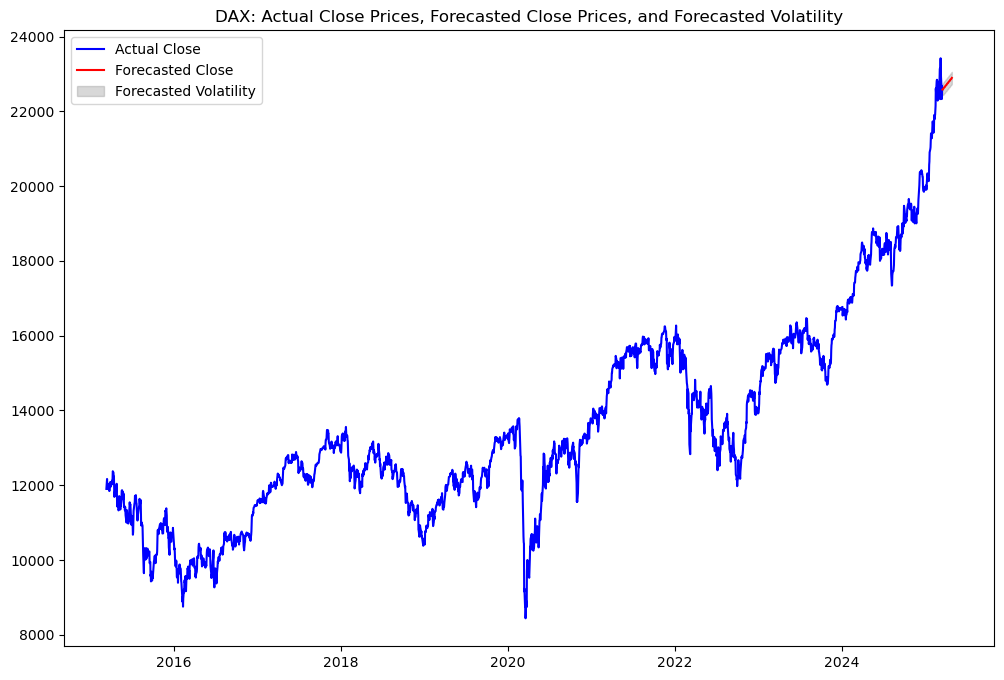

In [98]:
# Plot the actual close prices, forecasted close prices, and forecasted volatility
plt.figure(figsize=(12, 8))

# Plot the actual close prices
plt.plot(df.index, df['close'], label='Actual Close', color='blue')

# Plot the forecasted close prices
plt.plot(combined_arch_forecast.index, combined_arch_forecast['Predicted_Close'], label='Forecasted Close', color='red')

# Plot the forecasted volatility as a shaded area
plt.fill_between(combined_arch_forecast.index,
                 combined_arch_forecast['Predicted_Close'] - combined_arch_forecast['Forecasted_Volatility'],
                 combined_arch_forecast['Predicted_Close'] + combined_arch_forecast['Forecasted_Volatility'],
                 color='gray', alpha=0.3, label='Forecasted Volatility')

# Add title and legend
plt.title('DAX: Actual Close Prices, Forecasted Close Prices, and Forecasted Volatility')
plt.legend()
plt.show()

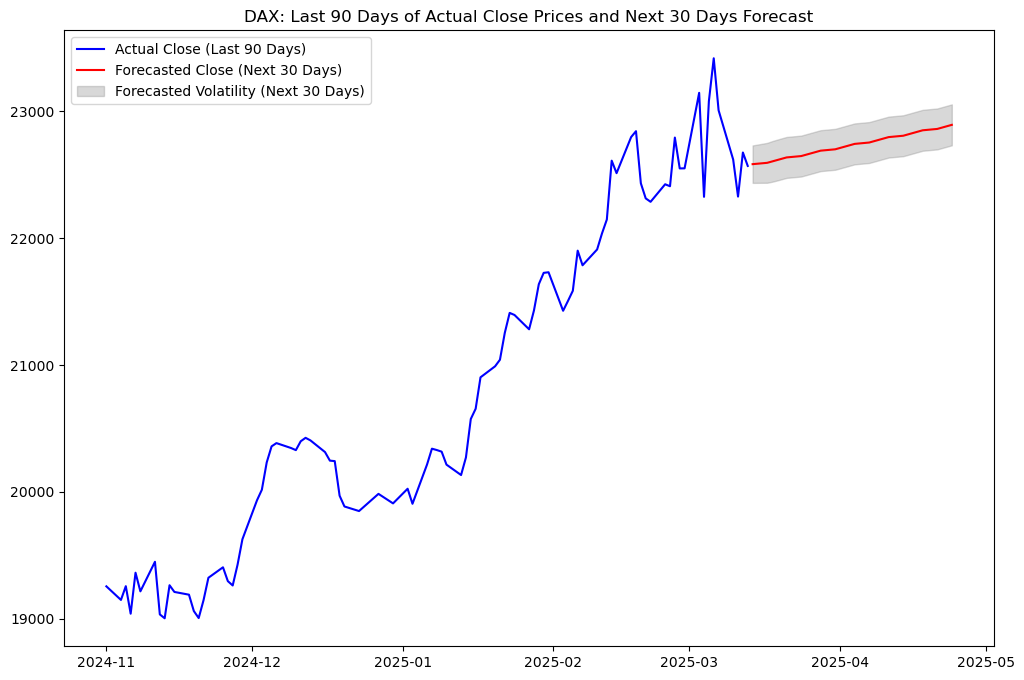

In [99]:
# Plot the last 90 days of actual close prices, the next 30 days of forecasted prices, and forecasted volatility
plt.figure(figsize=(12, 8))

# Plot the last 90 days of actual close prices
plt.plot(last_90_days.index, last_90_days, label='Actual Close (Last 90 Days)', color='blue')

# Plot the next 30 days of forecasted prices
plt.plot(combined_arch_forecast.index, combined_arch_forecast['Predicted_Close'], label='Forecasted Close (Next 30 Days)', color='red')

# Plot the forecasted volatility as a shaded area
plt.fill_between(combined_arch_forecast.index,
                 combined_arch_forecast['Predicted_Close'] - combined_arch_forecast['Forecasted_Volatility'],
                 combined_arch_forecast['Predicted_Close'] + combined_arch_forecast['Forecasted_Volatility'],
                 color='gray', alpha=0.3, label='Forecasted Volatility (Next 30 Days)')

# Add title and legend
plt.title('DAX: Last 90 Days of Actual Close Prices and Next 30 Days Forecast')
plt.legend()
plt.show()

In [108]:
print(combined_arch_forecast)

            Predicted_Close  Forecasted_Volatility
2025-03-14     22584.437133             147.653950
2025-03-17     22594.978949             157.331079
2025-03-18     22605.622488             160.171496
2025-03-19     22616.267434             161.029436
2025-03-20     22626.916646             161.290683
2025-03-21     22637.570044             161.370427
2025-03-24     22648.227629             161.394786
2025-03-25     22658.889402             161.402228
2025-03-26     22669.555363             161.404502
2025-03-27     22680.225511             161.405197
2025-03-28     22690.899847             161.405409
2025-03-31     22701.578370             161.405474
2025-04-01     22712.261081             161.405494
2025-04-02     22722.947980             161.405500
2025-04-03     22733.639066             161.405502
2025-04-04     22744.334340             161.405503
2025-04-07     22755.033802             161.405503
2025-04-08     22765.737451             161.405503
2025-04-09     22776.445288    

# Summary and Conclusion

## Data Overview
The dataset contains historical DAX index prices from 2015 to 2025. The data was cleaned, formatted, and analyzed to understand its behavior and forecast future prices and volatility.

## Stationarity Analysis
The Augmented Dickey-Fuller (ADF) test revealed that the time series is non-stationary, as the p-value was greater than 0.05. Differencing (d=1) was applied to make the series stationary.

## ARIMA Modeling
- The ARIMA model was used to forecast future prices. The best model selected through stepwise fitting was ARIMA(1,1,0) with a linear trend.
- The residuals of the ARIMA model were analyzed and found to exhibit no significant autocorrelation, indicating a good fit.

## Volatility Modeling
- ARCH and GARCH models were applied to model and forecast volatility.
- The ARCH(1) model showed significant coefficients, indicating the presence of heteroskedasticity.
- The GARCH(1,1) model provided a better fit, as indicated by lower AIC and BIC values compared to the ARCH model.

## Forecasting
- The ARIMA model was used to predict future DAX index prices for 30 business days.
- The GARCH model was used to forecast future volatility for the same period.
- Combined forecasts of predicted prices and volatility were visualized, showing the expected price range with volatility as a confidence band.

## Key Findings
1. The DAX index prices exhibit non-stationarity and require differencing for modeling.
2. ARIMA(1,1,0) is effective for forecasting prices, but the residuals suggest room for improvement.
3. Volatility clustering is evident, and GARCH(1,1) effectively captures this behavior.
4. The combined forecast provides a comprehensive view of expected prices and associated risks.

## Conclusion
The analysis demonstrates that ARIMA and GARCH models are effective tools for forecasting prices and volatility in financial time series. However, ARIMA alone is not suitable for trading decisions, as it does not account for volatility. The combined approach of ARIMA for price prediction and GARCH for volatility estimation provides a more robust framework for understanding future market behavior. Further improvements could involve incorporating external factors or exploring advanced models like SARIMA or hybrid approaches.

In [116]:
evaluation_df = pd.read_excel('Difference calculations.xlsx')
evaluation_df = evaluation_df.set_index('Trading Date')
evaluation_df = evaluation_df[['Predicted Close [a]', 'Actual Close [b]']]
evaluation_df
# # Combine actual and predicted values into a DataFrame
# evaluation_df = pd.DataFrame({
#     'Actual': df['close'][-len(predictions):],  # Actual values
#     'Predicted': predictions.values  # Predicted values
# })

# # Calculate metrics
# mae = mean_absolute_error(evaluation_df['Actual'], evaluation_df['Predicted'])
# mse = mean_squared_error(evaluation_df['Actual'], evaluation_df['Predicted'])
# rmse = mse ** 0.5
# mape = (abs(evaluation_df['Actual'] - evaluation_df['Predicted']) / evaluation_df['Actual']).mean() * 100
# r2 = r2_score(evaluation_df['Actual'], evaluation_df['Predicted'])

# # Print results
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"Mean Squared Error (MSE): {mse}")
# print(f"Root Mean Squared Error (RMSE): {rmse}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
# print(f"R-squared: {r2}")

,Predicted Close [a],Actual Close [b]
Trading Date,,
2025-03-14,22584.437133,22986.82
2025-03-17,22594.978949,23154.57
2025-03-18,22605.622488,23380.70
2025-03-19,22616.267434,23288.06
2025-03-20,22626.916646,22999.15
2025-03-21,22637.570044,22891.68
2025-03-24,22648.227629,22852.66
2025-03-25,22658.889402,23109.79


In [119]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Extract predicted and actual values
predicted = evaluation_df['Predicted Close [a]']
actual = evaluation_df['Actual Close [b]']

# Calculate metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
mape = (abs(actual - predicted) / actual).mean() * 100
r2 = r2_score(actual, predicted)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 461.31503437499987
Mean Squared Error (MSE): 246917.25006415608
Root Mean Squared Error (RMSE): 496.90768766860117
Mean Absolute Percentage Error (MAPE): 1.99%
R-squared (R²): -7.147198780174211


# GARCH

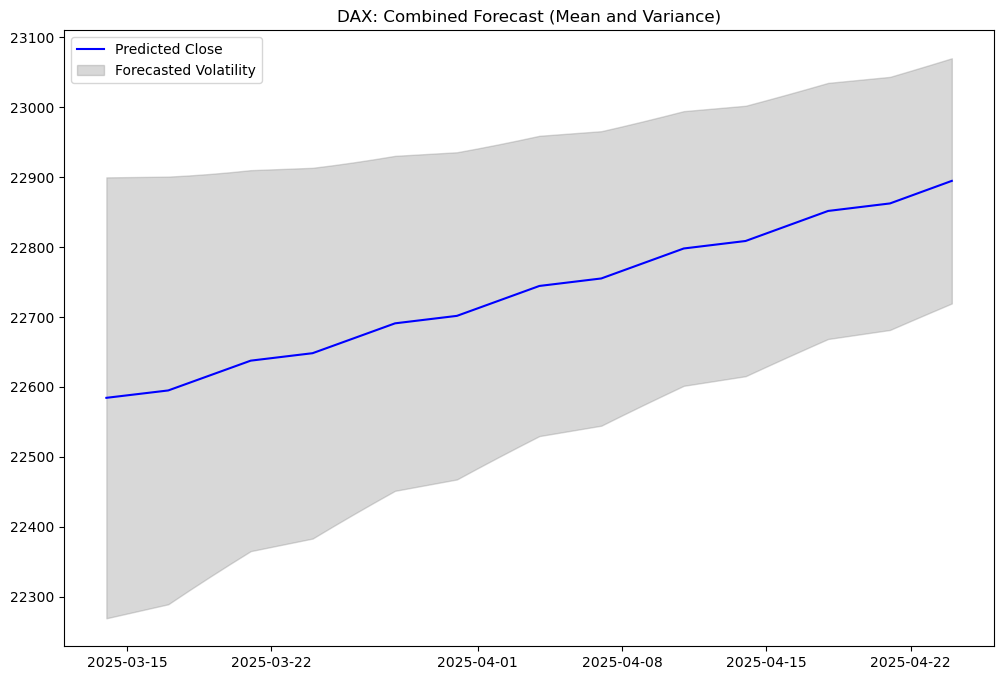

In [101]:
# Combine the ARIMA predicted close prices with the GARCH forecasted volatility
combined_forecast = pd.DataFrame({
    'Predicted_Close': future_df['Predicted_Close'],
    'Forecasted_Volatility': forecasted_volatility
}, index=future_dates)

# Plot the combined forecast
plt.figure(figsize=(12, 8))

# Plot the predicted close prices
plt.plot(combined_forecast.index, combined_forecast['Predicted_Close'], label='Predicted Close', color='blue')

# Plot the forecasted volatility as a shaded area
plt.fill_between(combined_forecast.index,
                 combined_forecast['Predicted_Close'] - combined_forecast['Forecasted_Volatility'],
                 combined_forecast['Predicted_Close'] + combined_forecast['Forecasted_Volatility'],
                 color='gray', alpha=0.3, label='Forecasted Volatility')

plt.title('DAX: Combined Forecast (Mean and Variance)')
plt.legend()
plt.show()

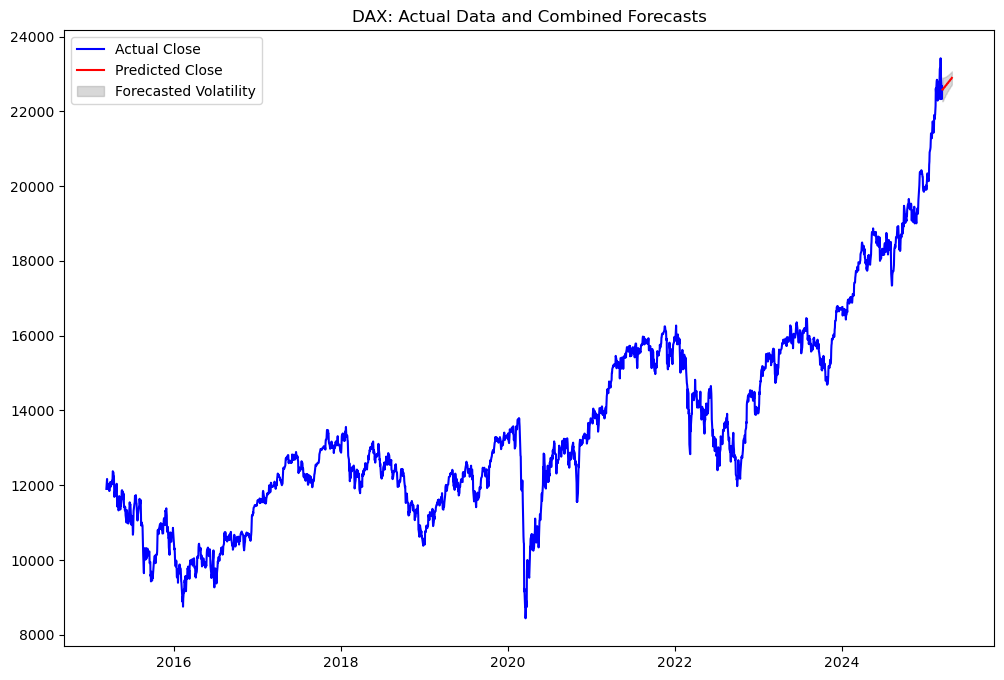

In [102]:
# Plot the actual data and combined forecasts
plt.figure(figsize=(12, 8))

# Plot the actual close prices
plt.plot(df.index, df['close'], label='Actual Close', color='blue')

# Plot the predicted close prices
plt.plot(combined_forecast.index, combined_forecast['Predicted_Close'], label='Predicted Close', color='red')

# Plot the forecasted volatility as a shaded area
plt.fill_between(combined_forecast.index,
                 combined_forecast['Predicted_Close'] - combined_forecast['Forecasted_Volatility'],
                 combined_forecast['Predicted_Close'] + combined_forecast['Forecasted_Volatility'],
                 color='gray', alpha=0.3, label='Forecasted Volatility')

plt.title('DAX: Actual Data and Combined Forecasts')
plt.legend()
plt.show()

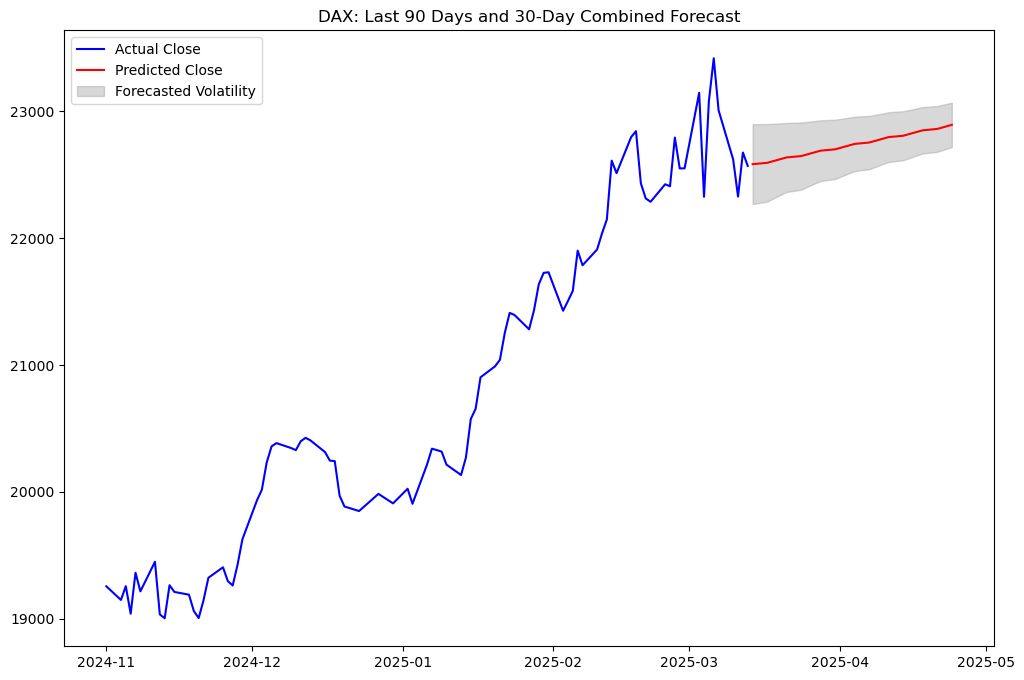

In [103]:
# Define the number of days to plot
days_to_plot = 90

# Get the last 90 days of actual data
last_90_days = df['close'].iloc[-days_to_plot:]

# Plot the last 90 days and the 30-day combined forecast
plt.figure(figsize=(12, 8))

# Plot the actual close prices
plt.plot(last_90_days.index, last_90_days, label='Actual Close', color='blue')

# Plot the predicted close prices
plt.plot(combined_forecast.index, combined_forecast['Predicted_Close'], label='Predicted Close', color='red')

# Plot the forecasted volatility as a shaded area
plt.fill_between(combined_forecast.index,
                 combined_forecast['Predicted_Close'] - combined_forecast['Forecasted_Volatility'],
                 combined_forecast['Predicted_Close'] + combined_forecast['Forecasted_Volatility'],
                 color='gray', alpha=0.3, label='Forecasted Volatility')

plt.title('DAX: Last 90 Days and 30-Day Combined Forecast')
plt.legend()
plt.show()

In [104]:
# Display the combined forecast values (mean and variance) in a table
combined_forecast

,Predicted_Close,Forecasted_Volatility
2025-03-14,22584.437133,315.062414
2025-03-17,22594.978949,305.604136
2025-03-18,22605.622488,296.609714
2025-03-19,22616.267434,288.061692
2025-03-20,22626.916646,279.943133
2025-03-21,22637.570044,272.237589
2025-03-24,22648.227629,264.929077
2025-03-25,22658.889402,258.002046
2025-03-26,22669.555363,251.441362
2025-03-27,22680.225511,245.232278


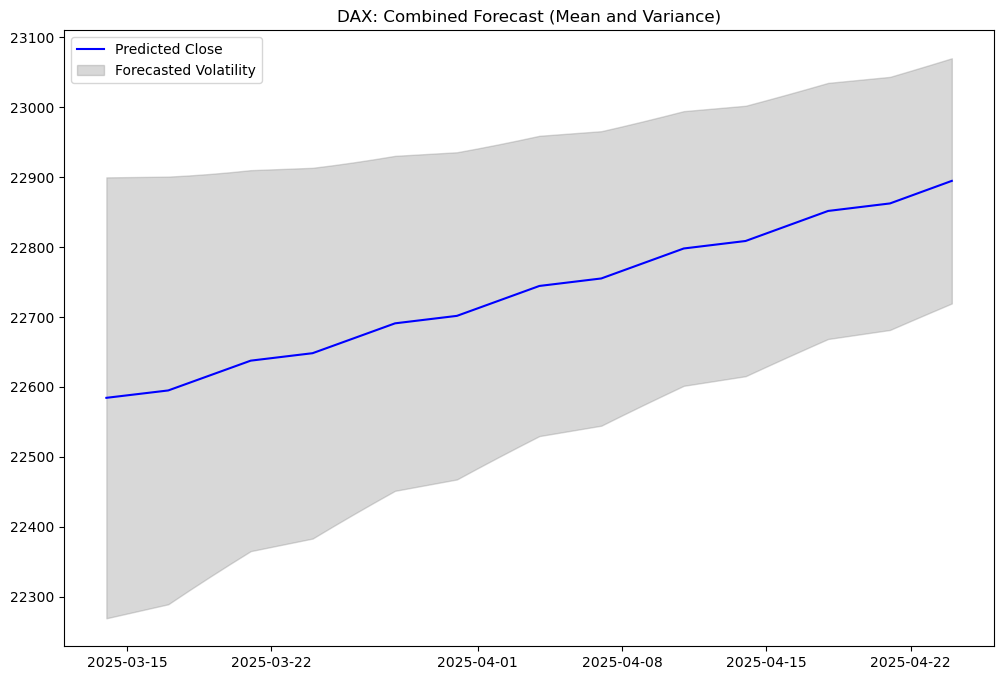

In [105]:
# Combine the ARIMA predicted close prices with the GARCH forecasted volatility
combined_forecast = pd.DataFrame({
    'Predicted_Close': future_df['Predicted_Close'],
    'Forecasted_Volatility': forecasted_volatility
}, index=future_dates)

# Plot the combined forecast
plt.figure(figsize=(12, 8))

# Plot the predicted close prices
plt.plot(combined_forecast.index, combined_forecast['Predicted_Close'], label='Predicted Close', color='blue')

# Plot the forecasted volatility as a shaded area
plt.fill_between(combined_forecast.index,
                 combined_forecast['Predicted_Close'] - combined_forecast['Forecasted_Volatility'],
                 combined_forecast['Predicted_Close'] + combined_forecast['Forecasted_Volatility'],
                 color='gray', alpha=0.3, label='Forecasted Volatility')

plt.title('DAX: Combined Forecast (Mean and Variance)')
plt.legend()
plt.show()

In [106]:


# # Fit a GARCH(1,1) model to the data
# garch_model = arch_model(df['close'], vol='Garch', p=1, q=1)
# garch_fit = garch_model.fit(disp='off')

# # Forecast future volatility
# steps = 30
# garch_forecast = garch_fit.forecast(horizon=steps)

# # Extract the forecasted volatility
# forecasted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# # Create future dates for the forecasted volatility
# future_vol_dates = pd.date_range(start=last_date, periods=steps + 1, freq='B')[1:]

# # Plot the forecasted volatility
# plt.figure(figsize=(12, 8))
# plt.plot(future_vol_dates, forecasted_volatility, label='Forecasted Volatility', color='blue')
# plt.title('DAX: Forecasted Volatility')
# plt.legend()
# plt.show()